<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/Vakhranyov_AY_Deep_learning_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом проекте я постарался с помощью предобученного берта сделать предсказания для текста на сентимент-анализ. Я взял датасет Sentiment Analysis Dataset.csv он есть здесь (https://github.com/vineetdhanawat/twitter-sentiment-analysis/blob/master/datasets/Sentiment%20Analysis%20Dataset.csv). Пояснений к нему, к сожалению, нет, поэтому точно сказать не могу, но, судя по всему, представленные в нём разбиты следующим образом: целевой класс (представлены единицей) — твиты с положительно-окрашенным мнением, всё остальное — представлено нулями. Помимо того, что я попробовал замерять лоссы на эпохах, также я использовал ф-меру для оценки модели.

В последнее время применение глубокого обучения для решения проблемы сентимент-анализа стало популярной темой исследований. Существуют различные архитектуры глубокого обучения и технологии, которые применяют для подобного рода анализа: эмбеддинги, автоэнкодеры, CNN, RNN, LSTM, применение аттеншн-механизма в RNN, MemNN, RecNN. Многие из этих методов глубокого обучения показали отличные результаты для различных задач сентимент-анализа. Если верить научным работам по теме, которые я просмотрел, то с развитием исследований и приложений глубокого обучения в ближайшем будущем появятся более интересные исследования применения глубокого обучения для сентимент-анализа.

In [ ]:
!pip install transformers
import pandas as pd
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data = pd.read_csv("Sentiment Analysis Dataset.csv")
max_len = 512

In [ ]:
import torch
def pad_tokenizer(tweets):
    tensor = torch.tensor(tokenizer(tweets)['input_ids'])
    zeros = torch.zeros(max_len-tensor.shape[0])
    max_len_tensor = torch.cat((tensor, zeros), 0)
    return max_len_tensor

In [ ]:
data = data[:200]
text_data = list(map(pad_tokenizer, data['SentimentText']))
new_data = list(zip(text_data, data['Sentiment']))
train = new_data[:1700]
test = new_data[170:200]

In [ ]:
from torch.utils.data import DataLoader
from transformers import AutoModel
loader = DataLoader(train, batch_size=8)
test_loader = DataLoader(test, batch_size=8)
model = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, bert, hidden_size=768, output_size=2):
        super().__init__()
        self.bert = bert
        self.classifier = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        pred = self.bert(x, attention_mask=(x!=0))
        return self.classifier(pred.pooler_output)

In [ ]:
epochs = 6
for param in model.parameters():
    param.requires_grad = False
loss = torch.nn.CrossEntropyLoss()
classifier = Classifier(model)
optimizer = torch.optim.Adam(classifier.classifier.parameters())

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
train_losses = list()
train_loss_per_epoch = list()
test_loss_per_epoch = list()
train_f1_scores_per_epoch = list()
test_f1_scores_per_epoch = list()
best_test_metric_value = float('inf')
for epoch in range(epochs):
    train_epoch_losses = list()
    test_epoch_losses = list()
    train_predictions = list()
    train_targets = list()
    test_predictions = list()
    test_targets = list()
    print(f'Epoch: {epoch}')
    classifier.train()
    for x, y in tqdm(loader):
        x = x.long()
        pred = classifier(x)
        train_loss = loss(pred, y)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(train_loss.item())
        train_epoch_losses.append(train_loss.item())
        train_predictions.extend(pred.argmax(dim=1).tolist())
        train_targets.extend(y.tolist())
    classifier.eval()
    for x, y in tqdm(test_loader):
        x = x.long()
        with torch.no_grad():
            pred = classifier(x)
            test_loss = loss(pred, y)
        test_epoch_losses.append(test_loss.item())
        test_predictions.extend(pred.argmax(dim=1).tolist())
        test_targets.extend(y.tolist())
    train_loss_per_epoch.append(np.mean(train_epoch_losses))
    test_loss_per_epoch.append(np.mean(test_epoch_losses))
    train_f1_scores_per_epoch.append(f1_score(train_targets, train_predictions))
    test_f1_scores_per_epoch.append(f1_score(test_targets, test_predictions))
    print(test_f1_scores_per_epoch)
    f1 = f1_score(y, pred.argmax(dim=1))
    print(f'Epoch {epoch}')
    print(f'Loss: train {train_loss_per_epoch[-1]:.2f} | test {test_loss_per_epoch[-1]:.2f}')
    print(f'F1 Score: train {train_f1_scores_per_epoch[-1]:.2f} | test {test_f1_scores_per_epoch[-1]:.2f}')
    #if best_test_metric_value > test_f1_scores_per_epoch[-1]:
    #  best_test_metric_value = test_f1_scores_per_epoch[-1]
    #else:
    #  break










  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0











  4%|▍         | 1/25 [00:17<06:51, 17.15s/it]








  8%|▊         | 2/25 [00:33<06:27, 16.84s/it]








 12%|█▏        | 3/25 [00:49<06:04, 16.59s/it]








 16%|█▌        | 4/25 [01:05<05:44, 16.40s/it]








 20%|██        | 5/25 [01:21<05:24, 16.24s/it]








 24%|██▍       | 6/25 [01:37<05:09, 16.32s/it]








 28%|██▊       | 7/25 [01:54<04:54, 16.38s/it]








 32%|███▏      | 8/25 [02:09<04:35, 16.23s/it]








 36%|███▌      | 9/25 [02:25<04:18, 16.13s/it]








 40%|████      | 10/25 [02:41<04:00, 16.06s/it]








 44%|████▍     | 11/25 [02:57<03:44, 16.02s/it]








 48%|████▊     | 12/25 [03:13<03:27, 15.99s/it]








 52%|█████▏    | 13/25 [03:29<03:11, 15.96s/it]








 56%|█████▌    | 14/25 [03:45<02:55, 15.95s/it]








 60%|██████    | 15/25 [04:01<02:39, 15.94s/it]








 64%|██████▍   | 16/25 [04:17<02:23, 15.93s/it]








 68%|██████▊   | 17/25 [04:33<02:07, 15.94s/it]








 72%|███████▏  | 18/25 [04:49<01:51, 15.93s/it]


[0.6976744186046512]
Epoch 0
Loss: train 0.66 | test 0.70
F1 Score: train 0.00 | test 0.70
Epoch: 1











  4%|▍         | 1/25 [00:15<06:22, 15.93s/it]








  8%|▊         | 2/25 [00:31<06:06, 15.92s/it]








 12%|█▏        | 3/25 [00:47<05:50, 15.92s/it]








 16%|█▌        | 4/25 [01:03<05:34, 15.92s/it]








 20%|██        | 5/25 [01:19<05:19, 15.96s/it]








 24%|██▍       | 6/25 [01:36<05:10, 16.32s/it]








 28%|██▊       | 7/25 [01:52<04:51, 16.20s/it]








 32%|███▏      | 8/25 [02:08<04:34, 16.12s/it]








 36%|███▌      | 9/25 [02:24<04:16, 16.06s/it]








 40%|████      | 10/25 [02:40<04:00, 16.03s/it]








 44%|████▍     | 11/25 [02:56<03:44, 16.00s/it]








 48%|████▊     | 12/25 [03:12<03:28, 16.00s/it]








 52%|█████▏    | 13/25 [03:28<03:11, 16.00s/it]








 56%|█████▌    | 14/25 [03:44<02:55, 15.97s/it]








 60%|██████    | 15/25 [04:00<02:39, 15.95s/it]








 64%|██████▍   | 16/25 [04:16<02:23, 15.95s/it]








 68%|██████▊   | 17/25 [04:32<02:07, 15.94s/it]








 72%|███████▏  | 18/25 [04:48<01:51, 15.93s/it]


[0.6976744186046512, 0.7555555555555556]
Epoch 1
Loss: train 0.67 | test 0.69
F1 Score: train 0.15 | test 0.76
Epoch: 2











  4%|▍         | 1/25 [00:15<06:22, 15.95s/it]








  8%|▊         | 2/25 [00:31<06:06, 15.94s/it]








 12%|█▏        | 3/25 [00:47<05:50, 15.94s/it]








 16%|█▌        | 4/25 [01:03<05:34, 15.95s/it]








 20%|██        | 5/25 [01:19<05:18, 15.94s/it]








 24%|██▍       | 6/25 [01:35<05:02, 15.93s/it]








 28%|██▊       | 7/25 [01:51<04:46, 15.92s/it]








 32%|███▏      | 8/25 [02:07<04:30, 15.91s/it]








 36%|███▌      | 9/25 [02:23<04:14, 15.92s/it]








 40%|████      | 10/25 [02:39<03:58, 15.91s/it]








 44%|████▍     | 11/25 [02:55<03:42, 15.91s/it]








 48%|████▊     | 12/25 [03:11<03:26, 15.91s/it]








 52%|█████▏    | 13/25 [03:26<03:10, 15.91s/it]








 56%|█████▌    | 14/25 [03:42<02:55, 15.92s/it]








 60%|██████    | 15/25 [04:00<02:42, 16.28s/it]








 64%|██████▍   | 16/25 [04:16<02:25, 16.21s/it]








 68%|██████▊   | 17/25 [04:32<02:08, 16.12s/it]








 72%|███████▏  | 18/25 [04:47<01:52, 16.06s/it]


[0.6976744186046512, 0.7555555555555556, 0.7659574468085106]
Epoch 2
Loss: train 0.68 | test 0.68
F1 Score: train 0.20 | test 0.77
Epoch: 3











  4%|▍         | 1/25 [00:15<06:21, 15.90s/it]








  8%|▊         | 2/25 [00:31<06:05, 15.91s/it]








 12%|█▏        | 3/25 [00:47<05:50, 15.91s/it]








 16%|█▌        | 4/25 [01:03<05:34, 15.91s/it]








 20%|██        | 5/25 [01:19<05:18, 15.91s/it]








 24%|██▍       | 6/25 [01:35<05:02, 15.90s/it]








 28%|██▊       | 7/25 [01:51<04:46, 15.91s/it]








 32%|███▏      | 8/25 [02:07<04:30, 15.91s/it]








 36%|███▌      | 9/25 [02:23<04:14, 15.91s/it]








 40%|████      | 10/25 [02:39<03:58, 15.91s/it]








 44%|████▍     | 11/25 [02:55<03:42, 15.91s/it]








 48%|████▊     | 12/25 [03:11<03:27, 15.94s/it]








 52%|█████▏    | 13/25 [03:26<03:11, 15.93s/it]








 56%|█████▌    | 14/25 [03:42<02:55, 15.97s/it]








 60%|██████    | 15/25 [03:58<02:39, 15.96s/it]








 64%|██████▍   | 16/25 [04:14<02:23, 15.95s/it]








 68%|██████▊   | 17/25 [04:30<02:07, 15.94s/it]








 72%|███████▏  | 18/25 [04:46<01:51, 15.95s/it]


[0.6976744186046512, 0.7555555555555556, 0.7659574468085106, 0.7368421052631577]
Epoch 3
Loss: train 0.69 | test 0.68
F1 Score: train 0.23 | test 0.74
Epoch: 4











  4%|▍         | 1/25 [00:15<06:22, 15.92s/it]








  8%|▊         | 2/25 [00:31<06:06, 15.91s/it]








 12%|█▏        | 3/25 [00:47<05:50, 15.92s/it]








 16%|█▌        | 4/25 [01:03<05:34, 15.92s/it]








 20%|██        | 5/25 [01:19<05:18, 15.94s/it]








 24%|██▍       | 6/25 [01:35<05:02, 15.94s/it]








 28%|██▊       | 7/25 [01:51<04:46, 15.94s/it]








 32%|███▏      | 8/25 [02:07<04:30, 15.93s/it]








 36%|███▌      | 9/25 [02:23<04:14, 15.93s/it]








 40%|████      | 10/25 [02:39<03:58, 15.92s/it]








 44%|████▍     | 11/25 [02:55<03:42, 15.92s/it]








 48%|████▊     | 12/25 [03:11<03:26, 15.92s/it]








 52%|█████▏    | 13/25 [03:27<03:11, 15.98s/it]








 56%|█████▌    | 14/25 [03:43<02:55, 15.96s/it]








 60%|██████    | 15/25 [03:59<02:39, 15.95s/it]








 64%|██████▍   | 16/25 [04:15<02:23, 15.95s/it]








 68%|██████▊   | 17/25 [04:30<02:07, 15.94s/it]








 72%|███████▏  | 18/25 [04:46<01:51, 15.94s/it]


[0.6976744186046512, 0.7555555555555556, 0.7659574468085106, 0.7368421052631577, 0.7567567567567567]
Epoch 4
Loss: train 0.67 | test 0.66
F1 Score: train 0.24 | test 0.76
Epoch: 5











  4%|▍         | 1/25 [00:16<06:24, 16.02s/it]








  8%|▊         | 2/25 [00:31<06:07, 16.00s/it]








 12%|█▏        | 3/25 [00:47<05:51, 15.98s/it]








 16%|█▌        | 4/25 [01:03<05:35, 15.97s/it]








 20%|██        | 5/25 [01:19<05:19, 15.97s/it]








 24%|██▍       | 6/25 [01:35<05:03, 15.96s/it]








 28%|██▊       | 7/25 [01:53<04:54, 16.37s/it]








 32%|███▏      | 8/25 [02:09<04:36, 16.24s/it]








 36%|███▌      | 9/25 [02:24<04:18, 16.15s/it]








 40%|████      | 10/25 [02:40<04:01, 16.10s/it]








 44%|████▍     | 11/25 [02:56<03:44, 16.05s/it]








 48%|████▊     | 12/25 [03:12<03:28, 16.03s/it]








 52%|█████▏    | 13/25 [03:28<03:12, 16.00s/it]








 56%|█████▌    | 14/25 [03:44<02:55, 16.00s/it]








 60%|██████    | 15/25 [04:00<02:39, 16.00s/it]








 64%|██████▍   | 16/25 [04:16<02:24, 16.01s/it]








 68%|██████▊   | 17/25 [04:32<02:07, 15.99s/it]








 72%|███████▏  | 18/25 [04:48<01:51, 15.99s/it]


[0.6976744186046512, 0.7555555555555556, 0.7659574468085106, 0.7368421052631577, 0.7567567567567567, 0.6470588235294117]
Epoch 5
Loss: train 0.69 | test 0.70
F1 Score: train 0.22 | test 0.65


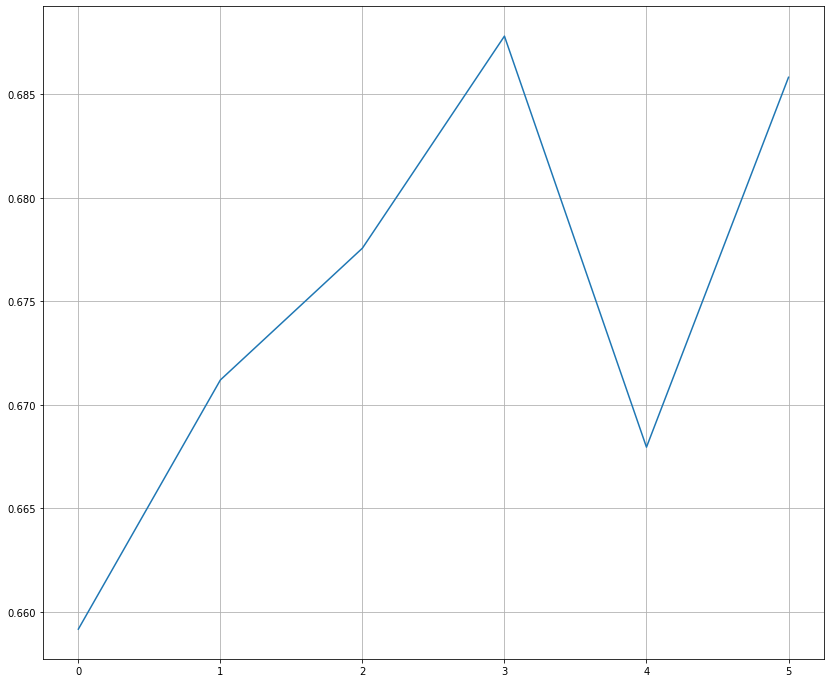

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(train_loss_per_epoch)
plt.grid()

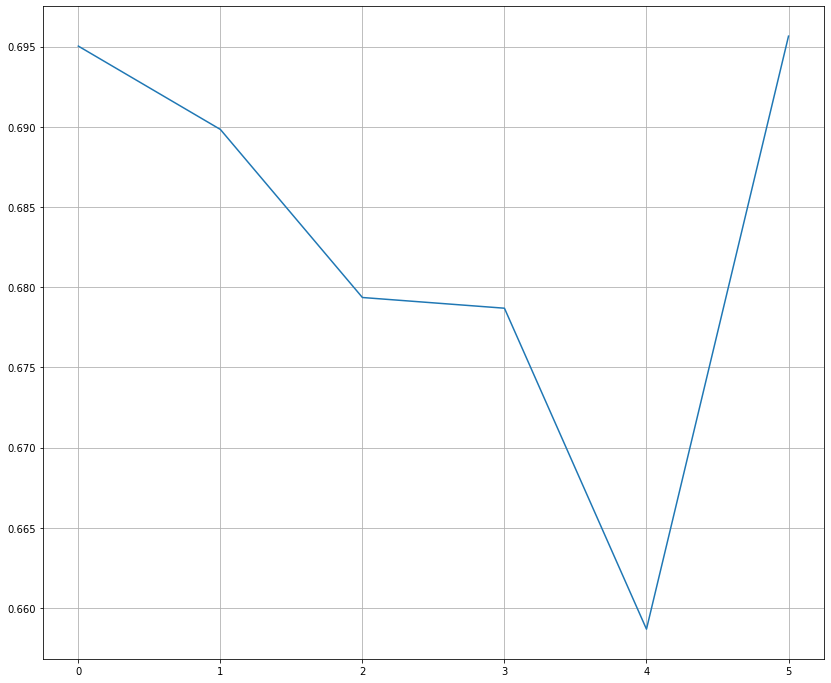

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(test_loss_per_epoch)
plt.grid()

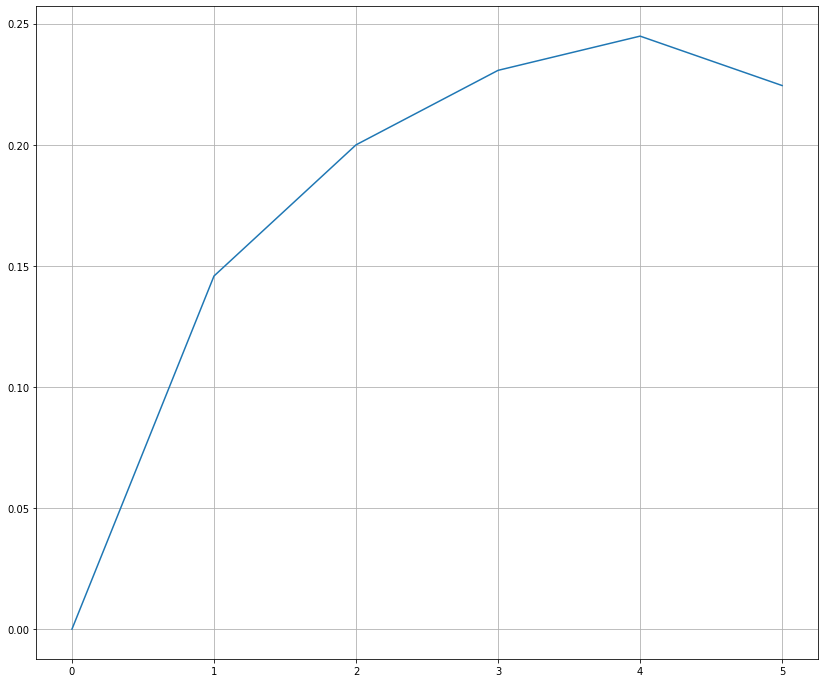

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(train_f1_scores_per_epoch)
plt.grid()

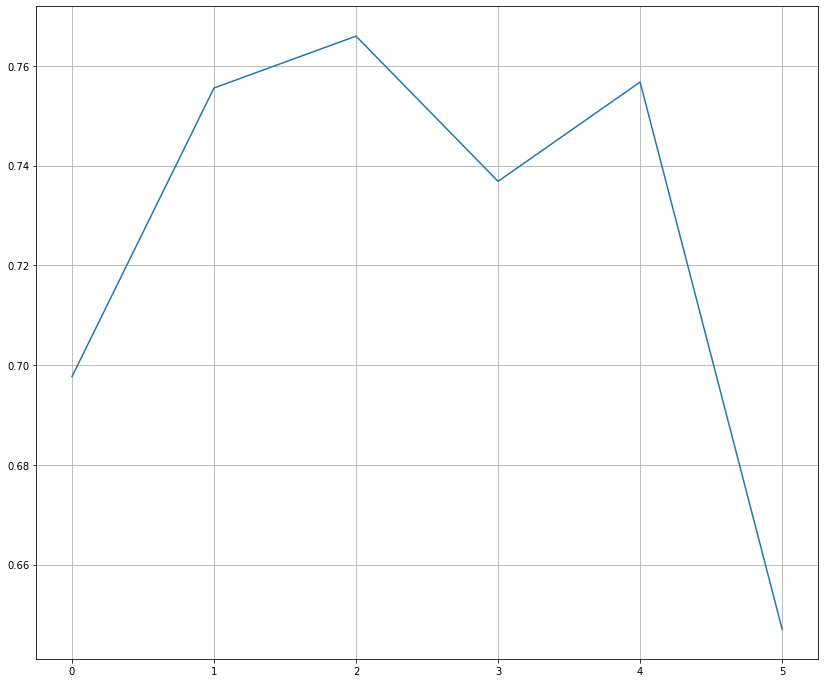

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(test_f1_scores_per_epoch)
plt.grid()

In [ ]:
print('Лучшая метрика на test:')
print('F1 test: ', max(test_f1_scores_per_epoch))

Лучшая метрика на test:
F1 test:  0.7659574468085106


Я выдающимися знаниями особо никогда не блистал, поэтому для меня даже достаточно простая задача (если сравнивать с другими вариантами проектов) давалась непросто. Наверное, главная проблема, с которой я столкнулся — это подсчёт ф-меры на большом количестве данных на тесте. На сотнях и десятках тысяч я упорно получал нули после каждой эпохи. В причнах этой проблемы, к сожалению, мне разобраться не удалось. Я пробовал увеличивать количество эпох обучения, но результат не менялся. Уменьшать learning rate я не стал, потому что по умолчанию он и так стоит небольшой, вряд ли это помогло бы с решением проблемы. В результате, относительного успеха удалось добиться, снизив объём данных до 2000.
Но здесь, само собой, были свои проблемы.
Например, ф-мера на трейне была довольно низкая, а лоссы на трейне вообще вели себя довольно хаотично. Также, как видно на графиках, на 6 (последней) эпохе резко портятся метрики, что, вероятнее всего, свидетельствует о переобучении модели. Думаю, что на таком количестве данных оптимально было бы остановиться на 5 эпохах.
Тем не менее, мне удалось получить ф-меру равную 0.77 на тесте, что является достаточно хорошим результатом.